In [424]:
import astroprov
from astropy.io.ascii import SExtractor
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import aperture_photometry
#import subproc

from astropy import wcs
from astropy.io import fits
import sys

from astroquery.simbad import Simbad
from astroquery.vizier import Vizier

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.table import Table, vstack
from astropy.table import Column

import collections
import subprocess
from astropy.io import ascii
import time
from astropy.utils.data import clear_download_cache
from astroquery.gaia import Gaia
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from bs4 import BeautifulSoup

In [12]:
clear_download_cache()

In [13]:
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print(table.get_qualified_name())

Retrieving tables...
Parsing tables...
Done.
external.external.apassdr9
external.external.gaiadr2_geometric_distance
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
public.public.hipparcos
public.public.hipparcos_newreduction
public.public.hubble_sc
public.public.igsl_source
public.public.igsl_source_catalog_ids
public.public.tycho2
public.public.dual
tap_config.tap_config.coord_sys
tap_schema.tap_schema.columns
tap_schema.tap_schema.key_columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_zero_point
gaiadr1.gaiadr1.allwise_best_neighbour
gaiadr1.gaiadr1.allwise_neighbourhood
gaiadr1.gaiadr1.gsc23_best_neighbour
gaiadr1.gaiadr1.gsc23_neighbourhood
gaiadr1.gaiadr1.ppmxl_best_neighbour
gaiadr1.gaiadr1.ppmxl_neighbourhood
gaiadr1.gaiadr1.sdss_dr9_best_neighbour
gaiadr1.gaiadr1.sdss_dr9_neighbourhood
gaiadr1.gaiadr1.tma

In [14]:
def makeDS9RegFile(sexTabList,fileNameBase,tabType):
    for tables in range(len(sexTabList)):
        if tabType == 'dao':
            xcoords = sexTabList[tables]['xcentroid']
            ycoords = sexTabList[tables]['ycentroid']
        elif tabType == 'sex':
            xcoords = sexTabList[tables]['X_IMAGE']
            ycoords = sexTabList[tables]['Y_IMAGE']
        elif tabType == 'iraf':
            xcoords = sexTabList[tables]['X_POS']
            ycoords = sexTabList[tables]['Y_POS']        
        else:
            print('tab type error')
            break
        bigString = 'global color=lightgreen\nimage\n'
        for x in range(len(xcoords)):
            bigString += 'circle({},{},5)\n'.format(xcoords[x],ycoords[x])
        fileName = fileNameBase + '.reg'
        with open(fileName,'w') as f:
            f.write(bigString)
#         print(fileName)
#         print(os.listdir('.'))

In [15]:
def load_wcs_from_file(filename,pixCoord):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    #print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed a NAXIS=2 image here.
    # Note also that the pixel coordinates are pairs of [X, Y], 
    # and since WCS built from FITS header automatically has
    # origin set to 1, [0, 0] is actually not inside the image.
    pixcrd = np.array(pixCoord, dtype=np.float_)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin" -- in this case we're declaring we
    # have 1-based (Fortran-like) coordinates.
    world = w.wcs_pix2world(pixcrd, 1)
    #print(world)
    return(world)

In [334]:
def queryObjectRegion(outputTable,searchRadius=5*u.arcsecond):
    imageCoords = []
    r = searchRadius
    
#     if inCat == 'dao':
#         xlabel = 'xcentroid'
#         ylabel = 'ycentroid'
#         label = 'id'
        
#     if inCat == 'sex':
#         xlabel = 'X_IMAGE'
#         ylabel = 'Y_IMAGE'
#         label = 'NUMBER'
        
    xlabel = 'RA'
    ylabel = 'DEC'
    label = 'NUMBER'
    
    flux = outputTable['FLUX_BEST']   
    ra = outputTable['RA']
    dec = outputTable['DEC']
    tableLength = len(outputTable)
    xcoord = outputTable['X_IMAGE']
    ycoord = outputTable['Y_IMAGE']
    imageCoords = [[x,y] for x,y in zip(xcoord,ycoord)]
    imageNames = outputTable['DIFF_NAME']
    customSimbad = Simbad()
    customSimbad.add_votable_fields('ra(d)','dec(d)','otype','sp')
    customSimbad.remove_votable_fields('coordinates')
    
    values = [['-'],[0],[0],['-'],['-'],[0],
              [0],[0],['-'],[0]]
    print(len(values))
    Names = ['MAIN_ID','RA_d','DEC_d','OTYPE','CLASS','X_IMAGE',
             'Y_IMAGE','flux','IMAGE','index']
    types = ['object','object','float64','object','object','float64',
             'float64','float64','object','int']     
    #result_table = Table([['-'],[0],[0],['-'],[0],[0],[0],['-'],[0]], names=('MAIN_ID','RA_d','DEC_d','OTYPE','xcentroid','ycentroid','flux','IMAGE','index'),dtype=('object','float64','float64','object','float64','float64','float64','object','object'))
    result_table = Table(values,names=Names,dtype=types)

    for x in range(len(imageCoords)):
        c = SkyCoord(ra[x],dec[x],frame='icrs',unit='deg')
        rt = customSimbad.query_region(c,radius=r)
        try:
            c = SkyCoord(ra[x],dec[x],frame='icrs',unit='deg')
            rt = customSimbad.query_region(c,radius=r)
            #print(rt)
            rowlist = []
            
            for y in range(len(rt[0])):
                rowlist.append(rt[0][y])
            rowlist.append(imageCoords[x][0])
            rowlist.append(imageCoords[x][1])
            rowlist.append(flux[x])
            rowlist.append(imageNames[x])
            rowlist.append(x)
            result_table.add_row(rowlist)

        except:
            #print('searchfailed')
            #result_table.add_row(['N/A',ra[x],dec[x],'Object Not Found',[imageCoords[x][0]],[imageCoords[x][1]],flux[x],imageNames[x],x])
            result_table.add_row(['N/A',ra[x],dec[x],'Object Not Found','0',[imageCoords[x][0]],
                                  [imageCoords[x][1]],flux[x],imageNames[x],x],
                                 mask=[False,False,False,False,True,False,
                                       False,False,False,False])
    
    return result_table

In [335]:
simtab = queryObjectRegion(otherGaiaTab)

10
INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


In [355]:
def keywordFunction(tab,keywordList):
    names = tab.colnames
    #print(names)
    goodColNames = {}
    values = []
    for keyword in keywordList:
        goodColName = [x for x in names if x.find(keyword) != -1]
        if len(goodColName) != 0:
            #print(goodColName)
            #ravalues = []
            for x in range(len(tab)):
                values.append(tab[goodColName[0]][x])
            break
    return values

In [352]:
def searchKeywords(tab):
    
    rakeyWords = ['RAJ2000','RA_ICRS_','RA_ICRS','_RA','RAh','RA_d']
    deckeyWords = ['DEJ2000','DE_ICRS_','DE_ICRS','_DE','DEC_d']
    possibleObjs = ['otype','object_type','objType','OTYPE']
    possibleClass = ['Class','objectClass','SpType','CLASS']
    
    ravalues = keywordFunction(tab,rakeyWords)
    decvalues = keywordFunction(tab,deckeyWords)
    
    names = tab.colnames
    objvalues = []
    objname = [x for x in possibleObjs if x in names]
    for x in range(len(tab)):
        if len(objname) != 0:
            objvalues.append(tab[objname[0]][x])
        else:
            objvalues.append('--')
    
    names = tab.colnames
    classvalues = []
    classname = [x for x in possibleClass if x in names]
    for x in range(len(tab)):
        if len(objname) != 0:
            classvalues.append(tab[classname[0]][x])
        else:
            classvalues.append('--')
        
    
    keywords  = ['Bmag','Vmag','Rmag','Fmag','Jmag','Hmag','Kmag','Nmag','FUVmag','NUVmag','umag','gmag','rmag','imag','zmag','ymag']
    totmags = []
    for y in range(len(tab)):
        values = [tab[x][y] if x in names else '--' for x in keywords]
        totmags.append(values)
    if len(ravalues) != 0:
        rowlist = [[x,y,z,w] for x,y,z,w in zip(ravalues,decvalues,objvalues,classvalues)]
        for x in range(len(rowlist)):
            rowlist[x].extend(totmags[x])
        #print(rowlist)
        return rowlist

In [259]:
#a = searchKeywords(vizierSearch[0:10])

In [260]:
#vizierSearch

In [ ]:
# def searchKeywordsMag(tab):
#     keywords  = ['Bmag','Vmag','Rmag','Fmag','Jmag','Hmag','Kmag','Nmag','FUVmag','NUVmag','umag','gmag','rmag','imag','zmag','ymag']
#     names = tab.colnames
#     values = [tab[x][0] if x in names else '--' for x in keywords]
#     return values

In [353]:
def queryObjectRegionVizier(outputTable,searchRadius=5*u.arcsecond):
    imageCoords = []
    r = searchRadius
        
    xlabel = 'RA'
    ylabel = 'DEC'
    label = 'NUMBER'
    
    flux = outputTable['FLUX_BEST']   
    ra = outputTable['RA']
    dec = outputTable['DEC']
    tableLength = len(outputTable)
    xcoord = outputTable['X_IMAGE']
    ycoord = outputTable['Y_IMAGE']
    imageCoords = [[x,y] for x,y in zip(xcoord,ycoord)]
    imageNames = outputTable['DIFF_NAME']
    #vs = Vizier(columns=['_RAJ2000', '_DEJ2000','MAG','Class','objectClass','otype','objecttype','objType','SpType'])
    values = [[0],[0],['-'],['-'],['-'],['-'],['-'],['-'],['-'],['-'],['-'],
              ['-'],['-'],['-'],['-'],['-'],['-'],['-'],['-'],['-'],[0],
              [0],[0],['-'],[0]]
    Names = ['RA_d','DEC_d','OTYPE','CLASS','Bmag','Vmag','Rmag','Fmag','Jmag','Hmag','Kmag',
             'Nmag','FUVmag','NUVmag','umag','gmag','rmag','imag','zmag','ymag','X_IMAGE',
             'Y_IMAGE','flux','IMAGE','index']
    #types = ['object']*len(Names)
    types = ['float64','float64','object','object','object','object','object','object','object','object','object',
             'object','object','object','object','object','object','object','object','object','float64',
             'float64','float64','object','int']
    #print(len(Names))
    result_table = Table(values,names=Names,dtype=types)
    
    for x in range(len(imageCoords)):
        #print(ra,dec)
        c = SkyCoord(ra[x],dec[x],frame='icrs',unit='deg')
        rt = Vizier.query_region(c,width=searchRadius)
        #print(rt.keys())
        if len(rt) != 0:
            #print(len(rt))
            for tabRange in range(len(rt)):
                #print('INDEX {}'.format(x))
                rowlist = searchKeywords(rt[tabRange])
                for row in rowlist:
                    row.append(imageCoords[x][0])
                    row.append(imageCoords[x][1])
                    row.append(flux[x])
                    row.append(imageNames[x])
                    row.append(x)
                    #print('rowlength',len(row))
                    try:
                        result_table.add_row(row)
                    except:
                        print('########################################')
                        print('broken imcoords{},tabrange{}'.format(x,tabRange))
                        print(rowlist)
                        print('########################################')

        else:
            #print('searchfailed')
            result_table.add_row([ra[x],dec[x],'Object Not Found','0','0','0','0','0','0','0','0',
                                  '0','0','0','0','0','0','0','0','0',[imageCoords[x][0]],
                                  [imageCoords[x][1]],flux[x],imageNames[x],x],
                                 mask=[False,False,False,True,True,True,True,True,True,True,True,
                                       True,True,True,True,True,True,True,True,True,False,
                                       False,False,False,False])

    
    return result_table

In [400]:
vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=2*u.arcsecond)

In [102]:
def findSeparation(ra1,dec1,ra2,dec2):
    c1 = SkyCoord(ra=ra1*u.degree,dec=dec1*u.degree)
    c2 = SkyCoord(ra=ra2*u.degree,dec=dec2*u.degree)
    sep = c1.separation(c2)
    separc = sep.arcsec
    return separc

In [114]:
def getTabValues(Tab,index,tabType,origra,origdec):
    rowlist = 'none'
    if tabType == 'simbad':
        otypename = 'OTYPE'
        source = 'SIMBAD'
    if tabType == 'vizier':
        source = 'VIZIER'
        otypename = 'CLASS'
    Tab = Tab[1:]
    df = Tab.to_pandas()
    df2 = df[df[otypename] != 'Object Not Found']
    df3 = df2[df2['index'] == index]
    if len(df3) != 0:
        ra = df3['RA_d'].tolist()
        dec = df3['DEC_d'].tolist()
        otype = df3[otypename].tolist()
        separations = [round(findSeparation(ra1,dec1,origra,origdec),3) for ra1,dec1 in zip(ra,dec)]
        rowlist = [[index,source,0,0,x,y,0,0,'magfilter',sep,z] for x,y,z,sep in zip(ra,dec,otype,separations)]
    return rowlist

In [391]:
def generateRow(Tab,index,origra,origdec,Names,tabType):
    rowlist = 'none'
    columnNames = Tab.colnames
    Tab = Tab[1:]
    df = Tab.to_pandas()
    df2 = df[df['OTYPE'] != 'Object Not Found']
    df3 = df2[df2['index'] == index]
    rows = []
    astroTab = Table.from_pandas(df3)
    #print('tab',index,len(astroTab))
    if len(df3) != 0:
        for x in range(len(astroTab)):
            ra1 = astroTab['RA_d'][x]
            dec1 = astroTab['DEC_d'][x]
            sep = round(findSeparation(ra1,dec1,origra,origdec),3)
            rowlist = [astroTab[name][x] if name in columnNames else '--' for name in Names]
            rowlist[0] = index
            rowlist[1] = tabType
            rowlist[10] = sep
            rows.append(rowlist)
        #print('rows',index,len(rows))
    return rows

In [375]:
def bigTable(origTab,simbadTab,vizierTab):
    origra = origTab['RA'].tolist()
    origdec = origTab['DEC'].tolist()
    origImage = origTab['IMAGE_NAME'].tolist()
    xim = origTab['X_IMAGE']
    yim = origTab['Y_IMAGE']
    origmag = origTab['MAG_BEST']
    magDiff = origTab['magDiff']
    searchTables = [simbadTab,vizierTab]
    searchTabNames = ['simbad','vizier']
    #result_table = Table([[0],[0],['-'],['-'],[0],[0],[0],['-'],[0]],names=('RA_d','DEC_d','Vmag','CLASS','xcentroid','ycentroid','flux','IMAGE','index'),dtype=('float64','float64','object','object','float64','float64','float64','object','int'))
    for x in range(len(origra)):
        if x == 0:

            namelist = ['OBJECT INDEX','SOURCE','X_IMAGE','Y_IMAGE','RA_d','DEC_d','MAG','MAG_DIFF','OTYPE','CLASS','SEPARATION',
                        'Bmag','Vmag','Rmag','Fmag','Jmag','Hmag','Kmag','Nmag',
                        'FUVmag','NUVmag','umag','gmag','rmag','imag','zmag','ymag']
#             types = ['int','object','float64','float64','float64','float64','float64','float64','object','object','float64',
#                      'object','object','object','object','object','object','object','object',
#                     'object','object','object','object','object','object','object','object']
            types = ['object']*len(namelist)
            rowlist = [[x],[origImage[x]],[xim[x]],[yim[x]],[origra[x]],[origdec[x]],[origmag[x]],[magDiff[x]],['-'],['-'],['-'],
                      ['-'],['-'],['-'],['-'],['-'],['-'],['-'],['-'],
                      ['-'],['-'],['-'],['-'],['-'],['-'],['-'],['-']]

            result_table = Table(rowlist,names=namelist,dtype=types)
            for tab in range(len(searchTables)):
                rowlist = generateRow(searchTables[tab],x,origra[x],origdec[x],namelist,searchTabNames[tab])
                if rowlist != 'none':
                    for row in rowlist:
                        result_table.add_row(row)
                        print('working')
        else:
            rowlist = [x,origImage[x],xim[x],yim[x],origra[x],origdec[x],origmag[x],magDiff[x],'-','-','-',
                      '-','-','-','-','-','-','-','-',
                      '-','-','-','-','-','-','-','-']
            result_table.add_row(rowlist)
            for tab in range(len(searchTables)):
                rowlist = generateRow(searchTables[tab],x,origra[x],origdec[x],namelist,searchTabNames[tab])
                if rowlist != 'none':
                    for row in rowlist:
                        result_table.add_row(row)
    return result_table

In [501]:
c = SkyCoord(ra=0*u.deg,dec=0*u.deg)
result_table1 = Vizier.query_region(c,radius=2*u.arcsec,catalog='Chandra')
#print(result_table[0])
result_table2 = Vizier.query_region(c,radius=10*u.arcsec,catalog='Rosat')
#print(result_table[0])
result_table3 = Vizier.query_region(c,radius=10*u.arcsec,catalog='XMM-Newton')

In [502]:
print(len(result_table1))
print(len(result_table2))
print(len(result_table3))

1
1
1


In [339]:
# def bigTable(origTab,simbadTab,vizierTab):
#     origra = origTab['RA'].tolist()
#     origdec = origTab['DEC'].tolist()
#     origImage = origTab['IMAGE_NAME'].tolist()
#     xim = origTab['X_IMAGE']
#     yim = origTab['Y_IMAGE']
#     origmag = origTab['MAG_BEST']
#     magDiff = origTab['magDiff']
#     searchTables = [simbadTab,vizierTab]
#     searchTabNames = ['simbad','vizier']
#     #result_table = Table([[0],[0],['-'],['-'],[0],[0],[0],['-'],[0]],names=('RA_d','DEC_d','Vmag','CLASS','xcentroid','ycentroid','flux','IMAGE','index'),dtype=('float64','float64','object','object','float64','float64','float64','object','int'))
#     for x in range(len(origra)):
#         if x == 0:
#             rowlist = [[x],[origImage[x]],[xim[x]],[yim[x]],[origra[x]],[origdec[x]],[origmag[x]],[magDiff[x]],['-'],[0],['-']]
#             namelist = ['OBJECT INDEX','SOURCE','X_IMAGE','Y_IMAGE','RA_d','DEC_d','MAG_DIFF','MAG','MAG_FILTER','SEPARATION','OTYPE']
#             types = ['int','object','float64','float64','float64','float64','float64','float64','object','float64','object']
#             result_table = Table(rowlist,names=namelist,dtype=types)
#             for tab in range(len(searchTables)):
#                 rowlist = getTabValues(searchTables[tab],x,searchTabNames[tab],origra[x],origdec[x])
#                 if rowlist != 'none':
#                     for row in rowlist:
#                         result_table.add_row(row,mask=[True,False,True,True,False,False,True,True,True,False,False])
#         else:
#             rowlist = [x,origImage[x],xim[x],yim[x],origra[x],origdec[x],origmag[x],magDiff[x],'-',0,'-']
#             result_table.add_row(rowlist,mask=[False,False,False,False,False,False,False,False,True,True,True])
#             for tab in range(len(searchTables)):
#                 rowlist = getTabValues(searchTables[tab],x,searchTabNames[tab],origra[x],origdec[x])
#                 if rowlist != 'none':
#                     for row in rowlist:
#                         result_table.add_row(row,mask=[True,False,True,True,False,False,True,True,True,False,False])
#     return result_table

In [392]:
simbadSearch = queryObjectRegion(otherGaiaTab,searchRadius=2*u.arcsec)
vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=2*u.arcsec)

10
INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]
INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]
########################################
broken imcoords7,tabrange41
[['18 52 38.105', '+47 23 37.64', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', 847.0221, 792.5739, 4922.818, 'diff_imNo31_channel9_ccd9.fits', 7]]
########################################
########################################
broken imcoords7,tabrange52
[['18 52 38.1', '+47 23 38', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', 847.0221, 792.5739, 4922.818, 'diff_imNo31_channel9_ccd9.fits', 7]]
########################################
########################################
broken imcoords11,tabrange42
[['18 52 15.907', '+43 44 36.92', '--', '--', '--', '--', '--', '--', '-

In [395]:
bigtab = bigTable(otherGaiaTab,simbadSearch,vizierSearch)

In [ ]:
def getPanStarCutOut(ra,dec):
    url = 'https://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={}%2C{}&filter=color&filter=g&filter=r&filter=i&filter=z&filter=y&filetypes=stack&auxiliary=data&size={}&output_size=0&verbose=0&autoscale=99.500000&catlist='.format(ra,dec,size)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    th = soup.findAll('td')
    try:
        link = th[1]
        downLink = link.findAll('img')
        downCut = downLink[0]['src']
        loc1 = downCut.find('cgi-bin')
        loc2 = downCut.find('=/') + len('=/')
        if loc1 != -1:
            if loc2 != -1:
                newCut = downCut[:loc1] + downCut[loc2:]

        loc3 = newCut.find('&')
        smallCut = newCut[:loc3]
        http = 'https:'+smallCut
        print(http)
        subprocess.call(['wget','-O','/home/mj1e16/cutOuts/{}'.format(outname),http])
    except:
        print('WARNING - panstarrs image note found ra = {}, dec = {}'.format(ra,dec))


In [508]:
kepler = ascii.read('/home/mj1e16/outTables15/firstPassTransients15.csv')
print(len(kepler))
# kepler = ascii.read('/home/mj1e16/outTables15/secondPassTransients15.csv')
# print(len(kepler))

In [509]:
indexes = range(len(kepler))
kepler['OBJECT INDEX'] = indexes

In [511]:
def XraySearch(tab):
    indexref = 'ooo'
    chandra = {}
    rosat = {}
    xmm = {}
    for x in range(len(tab)):
        index = tab['OBJECT INDEX'][x]
        if index != indexref:
            RA = tab['RA'][x]
            DEC = tab['DEC'][x]
            #print(tab['RA_d'][x],tab['DEC_d'][x])
            c = SkyCoord(ra=RA*u.deg,dec=DEC*u.deg)
            result_table1 = Vizier.query_region(c,radius=2*u.arcsec,catalog='Chandra')
            if len(result_table1) > 0:
                chandra[str(x)] = result_table1
                print('Chandra',result_table1,x)
            #print(result_table[0])
            result_table2 = Vizier.query_region(c,radius=10*u.arcsec,catalog='Rosat')
            if len(result_table2) > 0:
                rosat[str(x)] = result_table2
                print('Rosat',result_table2,x)
            #print(result_table[0])
            result_table3 = Vizier.query_region(c,radius=10*u.arcsec,catalog='XMM-Newton')
            if len(result_table3) > 0:
                xmm[str(x)] = result_table3
                print('XMM',result_table3,x)
    #             for y in range(len(result_table3)):
    #                 print(result_table3[y])
        indexref = tab['OBJECT INDEX'][x]
    return([chandra,rosat,xmm])

In [513]:
xrayobs = XraySearch(kepler)

('XMM', TableList with 1 tables:
	'0:II/356/xmmom41s' with 44 column(s) and 2 row(s) , 95)
('XMM', TableList with 2 tables:
	'0:IX/55/xmm3r8s' with 17 column(s) and 1 row(s) 
	'1:IX/54/xmm3r7s' with 17 column(s) and 1 row(s) , 106)
('XMM', TableList with 1 tables:
	'0:II/356/xmmom41s' with 44 column(s) and 1 row(s) , 498)
('XMM', TableList with 1 tables:
	'0:IX/55/xmm3r8s' with 17 column(s) and 1 row(s) , 692)
('XMM', TableList with 1 tables:
	'0:II/356/xmmom41s' with 44 column(s) and 1 row(s) , 1053)
('XMM', TableList with 4 tables:
	'0:IX/55/xmm3r8s' with 17 column(s) and 1 row(s) 
	'1:IX/50/xmm3r6s' with 17 column(s) and 1 row(s) 
	'2:IX/46/xmm3r5s' with 17 column(s) and 1 row(s) 
	'3:IX/54/xmm3r7s' with 17 column(s) and 1 row(s) , 1229)
('XMM', TableList with 4 tables:
	'0:IX/55/xmm3r8s' with 17 column(s) and 1 row(s) 
	'1:IX/50/xmm3r6s' with 17 column(s) and 1 row(s) 
	'2:IX/46/xmm3r5s' with 17 column(s) and 1 row(s) 
	'3:IX/54/xmm3r7s' with 17 column(s) and 1 row(s) , 1242)
('XMM

ConnectionError: HTTPConnectionPool(host='vizier.u-strasbg.fr', port=80): Max retries exceeded with url: /viz-bin/votable (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x7fb25ac53190>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))

In [504]:
indexref = 'ooo'
chandra = {}
rosat = {}
xmm = {}
for x in range(len(bigtab)):
    index = bigtab['OBJECT INDEX'][x]
    if index != indexref:
        RA = bigtab['RA_d'][x]
        DEC = bigtab['DEC_d'][x]
        #print(bigtab['RA_d'][x],bigtab['DEC_d'][x])
        c = SkyCoord(ra=RA*u.deg,dec=DEC*u.deg)
        result_table1 = Vizier.query_region(c,radius=2*u.arcsec,catalog='Chandra')
        if len(result_table1) > 0:
            chandra[str(x)] = result_table1
            print('Chandra',result_table1,x)
        #print(result_table[0])
        result_table2 = Vizier.query_region(c,radius=10*u.arcsec,catalog='Rosat')
        if len(result_table2) > 0:
            rosat[str(x)] = result_table2
            print('Rosat',result_table2,x)
        #print(result_table[0])
        result_table3 = Vizier.query_region(c,radius=10*u.arcsec,catalog='XMM-Newton')
        if len(result_table3) > 0:
            xmm[str(x)] = result_table3
            print('XMM',result_table3,x)
#             for y in range(len(result_table3)):
#                 print(result_table3[y])
    indexref = bigtab['OBJECT INDEX'][x]

('XMM', TableList with 1 tables:
	'0:II/356/xmmom41s' with 44 column(s) and 2 row(s) , 6)
     XMMOM       IDsum   ObsID       ID   UVW2r ... xUVM2 xUVW1  xU  xB  xV
                                           arcs ...                        
---------------- ----- ---------- ------- ----- ... ----- ----- --- --- ---
J193935.4+490024  8283 0763490701 4936259    -- ...    --    --  --   0  --
J193935.8+490028  8283 0763490701 4936334    -- ...    --    --  --   1  --
('XMM', TableList with 1 tables:
	'0:II/356/xmmom41s' with 44 column(s) and 1 row(s) , 8)
     XMMOM       IDsum   ObsID       ID    UVW2r  ... xUVM2 xUVW1  xU  xB  xV
                                            arcs  ...                        
---------------- ----- ---------- ------- ------- ... ----- ----- --- --- ---
J185238.1+472337  8001 0782600101 4691113   47.86 ...     0     0   0  --   0


In [422]:
RA = bigtab['RA_d'][8]
DEC = bigtab['DEC_d'][8]
#print(bigtab['RA_d'][x],bigtab['DEC_d'][x])
c = SkyCoord(ra=RA*u.deg,dec=DEC*u.deg)
result_table3 = Vizier.query_region(c,radius=10*u.arcsec,catalog='XMM-Newton')

In [420]:
RA = bigtab['RA_d'][6]
DEC = bigtab['DEC_d'][6]
#print(bigtab['RA_d'][x],bigtab['DEC_d'][x])
c = SkyCoord(ra=RA*u.deg,dec=DEC*u.deg)
result_table3 = Vizier.query_region(c,radius=10*u.arcsec,catalog='XMM-Newton')

In [434]:
df = bigtab
df2 = df[df['OBJECT INDEX'] == 7]
df2

OBJECT INDEX,SOURCE,X_IMAGE,Y_IMAGE,RA_d,DEC_d,MAG_DIFF,MAG,OTYPE,CLASS,SEPARATION,Bmag,Vmag,Rmag,Fmag,Jmag,Hmag,Kmag,Nmag,FUVmag,NUVmag,umag,gmag,rmag,imag,zmag,ymag
object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
7,kplr2010078174524_ffi-cal.fits[9],847.0221,792.5739,283.158814152,47.3938373268,15.7695,-4.343615660343915,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
7,simbad,--,--,283.1588365335496,47.3937710691911,--,--,Star,F3V,0.245,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
7,vizier,847.0221,792.5739,283.159039,47.393848,--,--,--,--,0.549,13.9,--,13.2,--,--,--,--,--,--,--,--,--,--,--,--,--
7,vizier,847.0221,792.5739,283.15891,47.39377,--,--,--,--,0.337,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
7,vizier,847.0221,792.5739,283.158853,47.393884,--,--,--,--,0.193,--,--,--,--,--,--,--,--,--,--,--,--,13.33,--,--,--
7,vizier,847.0221,792.5739,283.158907,47.393826,--,--,--,--,0.23,--,--,13.01,--,--,--,--,--,--,--,--,--,--,--,--,--
7,vizier,847.0221,792.5739,283.158806,47.393713,--,--,--,--,0.448,--,--,12.78,--,--,--,--,--,--,--,--,--,--,--,--,--
7,vizier,847.0221,792.5739,283.158839,47.393789,--,--,--,--,0.184,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
7,vizier,847.0221,792.5739,283.1588389,47.3937889,--,--,--,--,0.184,13.51,13.36,13.36,--,12.346,12.16,12.079,--,--,--,--,--,--,--,--,--


In [514]:
df = bigtab
df2 = df[df['OBJECT INDEX'] == 31]
print(df2['RA_d'][0],df2['DEC_d'][0])

(297.5177467782924, 43.605476931435)


In [494]:
df  = bigtab.to_pandas()
df2 = df[df['SOURCE'] == 'simbad']
df2

,OBJECT INDEX,SOURCE,X_IMAGE,Y_IMAGE,RA_d,DEC_d,MAG_DIFF,MAG,OTYPE,CLASS,...,Kmag,Nmag,FUVmag,NUVmag,umag,gmag,rmag,imag,zmag,ymag
7,6,simbad,--,--,294.897,49.0067,--,--,RGB*,,...,--,--,--,--,--,--,--,--,--,--
9,7,simbad,--,--,283.159,47.3938,--,--,Star,F3V,...,--,--,--,--,--,--,--,--,--,--
77,11,simbad,--,--,283.066,43.7436,--,--,EB*Algol,,...,--,--,--,--,--,--,--,--,--,--
177,26,simbad,--,--,282.703,48.5992,--,--,RotV*,,...,--,--,--,--,--,--,--,--,--,--
184,31,simbad,--,--,297.517,43.6054,--,--,V*,,...,--,--,--,--,--,--,--,--,--,--
196,32,simbad,--,--,284.144,49.036,--,--,Star,,...,--,--,--,--,--,--,--,--,--,--


In [ ]:
goodCatDict = {'7':['McMahon+','STScI','Monet+','NOMAD','GSC2.3','PPMX','PPMXL','XPM','UCAC4','IGSL','CMC15','URAT1',
                    'Gaia DR1','HSOY','UCAC5','FON','Gaia DR2','I/347/gaia2dis','II/271A/patch2','WISE','AllWISE',
                   ]}

In [ ]:
#6,26,7,11 are all very similar
#31 is similar and includes irfrared: II/297/irc 
goodCatDict = {'7':['NOMAD','PPMX','PPMXL','XPM','UCAC4','IGSL','CMC15','URAT1','Gaia DR1','HSOY','UCAC5','FON',
                    'Gaia DR2','I/347/gaia2dis','WISE','AllWiSE','II/335/galex_ais','PS1','gkisl','V/133/kic',
                   'VI/145/attitude','J/ApJS/224/12/table6','LAMOST'],
              '11':['I/284/out','NOMAD','I/305/out','PPMX','PPMXL','XPM','UCAC4','IGSL','CMC15','URAT1','Gaia DR1',
                    'HSOY','UCAC5','FON', 'Gaia DR2','I/347/gaia2dis','WISE','AllWiSE','II/335/galex_ais','II/336/apass9',
                   'PS1','V/133/kic','MORX','LAMOST','J/ApJS/199/24/table1','J/ApJS/224/12/tce','J/AJ/142/160/table3', #table3 details it an an eclipsing ibnary
                   'J/PASP/124/1279/table1','J/AJ/155/177/table2','J/AJ/156/241/table4','J/MNRAS/437/3473/catalog',
                   ,'J/MNRAS/463/4210/ucac4rpm'],
              '30':['GSC2.3','PPMXL','IGSL','II/294/sdss7','PS1','V/139/sdss9','V/147/sdss12','B/gcvs/gcvs_cat',
                    'B/vsx/vsx','J/AJ/144/24/kisdr2'],
              '31':[]} 

In [528]:
goodcatDict = {'6':['PS1','AllWiSE','LAMOST'],
              '7':['PS1','AllWiSE','LAMOST'],
              '11':['PS1','AllWiSE','LAMOST'],
              '26':['PS1','AllWiSE','LAMOST'],
              '30':['PS1'],
              '31':['PS1','AllWiSE','LAMOST']}

In [537]:
goodcatKeys = list(goodcatDict.keys())
fullcolumns = []
fullTabs = []
for x in range(len(bigtab)):
    index = bigtab['OBJECT INDEX'][x]
    if index != indexref:
        RA = bigtab['RA_d'][x]
        DEC = bigtab['DEC_d'][x]
        #print(bigtab['RA_d'][x],bigtab['DEC_d'][x])
        c = SkyCoord(ra=RA*u.deg,dec=DEC*u.deg)
        if str(x) in goodcatKeys:
            for y in range(len(goodcatDict[str(x)])):
                result_table1 = Vizier.query_region(c,radius=2*u.arcsec,catalog=goodcatDict[str(x)][y])
                fullTabs.append(result_table1)
                if len(result_table1) != 0:
                    print(result_table1[0])
                    columns = result_table1[0].colnames
                    fullcolumns.extend(columns)
                else:
                    print('none in catalogue '+goodcatDict[str(x)][y])
cols = list(set(fullcolumns))
print(cols)

   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag yFlags
     deg           deg                         ...   mag     mag         
------------- ------------- ------------------ ... ------- ------- ------
294.897483880  49.006710600 166802948975078734 ... 12.5489  0.0008 115000
      AllWISE         RAJ2000     DEJ2000    Im ...  e_pmDE  qph   d2M   _2M
                        deg         deg         ... mas / yr       arcs     
------------------- ----------- ----------- --- ... -------- ---- ------ ---
J193935.39+490024.1 294.8974946  49.0067145  Im ...       32 AAAU  0.067  2M
 sp   ObsID          Target       ...  snrz         z         magType
                                  ...                                
--- --------- ------------------- ... ------ ---------------- -------
 sp 362704043 J193935.39+490024.1 ... 188.30    -0.0002761244      Kp
   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag yFlags
     deg           deg                    

In [600]:
def vizierSearch(tab,cat):
    result_table = []
    indexref = 'none'
    indexes = []
    for x in range(len(tab)):
        index = tab['OBJECT INDEX'][x]
        if index != indexref:
            RA = tab['RA_d'][x]
            DEC = tab['DEC_d'][x]
            #print(bigtab['RA_d'][x],bigtab['DEC_d'][x])
            c = SkyCoord(ra=RA*u.deg,dec=DEC*u.deg)
            result_table_list = Vizier.query_region(c,radius=2*u.arcsec,catalog=cat)
            if len(result_table_list) != 0:
                indexes.append(index)
                if len(result_table) == 0:
                    #result_table_list = Vizier.query_region(c,radius=2*u.arcsec,catalog=cat)
                    result_table = result_table_list[0][0]
                else:
                    res_tab = result_table_list[0][0]
                    result_table = vstack([result_table,res_tab])
        indexref = index
        
#     aa = Column([], name='aa')
#     t.add_column(aa, index=0)
    result_table['index'] = indexes
    return result_table

In [601]:
ps1 = vizierSearch(bigtab,'PS1')

In [603]:
wise = vizierSearch(bigtab,'AllWiSE')

In [604]:
LAMOST = vizierSearch(bigtab,'LAMOST')

In [634]:
var = vizierSearch(bigtab,'J/AJ/156/241/')

In [635]:
var

ATOID,RAJ2000,DEJ2000,fp-lngfitper,fp-lngmin-c,fp-lngmax-c,fp-lngmin-o,fp-lngmax-o,fp-period,fp-min-o,fp-max-o,df-meanPvar,ls-c-med,ls-o-med,ls-Pday,Class,index
,deg,deg,d,mag,mag,mag,mag,d,mag,mag,,mag,mag,d,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,str7,int64
J283.0662+43.7434,283.06627,43.74347,557.486816,13.142004,13.020385,12.781275,12.687572,1.147959,12.776409,12.692467,96.8,13.082,12.738,1.147574,IRR,11
J282.7027+48.5990,282.70279,48.59907,36.349949,13.547061,13.528368,13.257691,13.235495,--,--,--,286.7,13.535,13.241,1.844570,dubious,26
J297.5174+43.6055,297.51740,43.60550,482.351959,17.315561,16.112406,14.749211,13.770937,1.993250,14.641975,13.753876,589.6,16.378,13.977,573.643895,LPV,31
J284.1441+49.0360,284.14410,49.03601,82.190224,14.071168,14.019384,13.550295,13.496283,8.969673,13.572492,13.507217,30.9,14.054,13.533,8.975485,IRR,32


In [ ]:
goodcatKeys = list(goodcatDict.keys())
fullcolumns = []
fullTabs = []
if str(x) in goodcatKeys:
    for y in range(len(goodcatDict[str(x)])):
        for x in range(len(bigtab)):
            index = bigtab['OBJECT INDEX'][x]
            if index != indexref:
                RA = bigtab['RA_d'][x]
                DEC = bigtab['DEC_d'][x]
                #print(bigtab['RA_d'][x],bigtab['DEC_d'][x])
                c = SkyCoord(ra=RA*u.deg,dec=DEC*u.deg)

                result_table1 = Vizier.query_region(c,radius=2*u.arcsec,catalog=goodcatDict[str(x)][y])
                fullTabs.append(result_table1)
                if len(result_table1) != 0:
                    print(result_table1[0])
                    columns = result_table1[0].colnames
                    fullcolumns.extend(columns)
                else:
                    print('none in catalogue '+goodcatDict[str(x)][y])
cols = list(set(fullcolumns))
print(cols)

In [570]:
#cols
colList = cols
colListNew = [x for x in colList if x[0:2] != 'e_']
colListNew = [x for x in colListNew if x != 'qph']
colListNew = [x for x in colListNew if 'Flag' not in x]
colListNew = [x for x in colListNew if x != 'ccf']
colListNew = [x for x in colListNew if x != 'snrr']
colListNew = [x for x in colListNew if x != '_2M']
colListNew = [x for x in colListNew if x != 'd2M']
colListNew = [x for x in colListNew if x != 'Im']
colListNew = [x for x in colListNew if x != 'sp']

print(colListNew)
print(len(colListNew))

['AllWISE', 'W2mag', 'Nd', 'gKmag', 'rKmag', 'Epoch', 'ex', 'Hmag', 'pmDE', 'Ns', 'zmag', 'snrg', 'snri', 'f_objID', 'yKmag', 'Qual', 'Kmag', 'snru', 'W1mag', 'ymag', 'snrz', 'Target', 'W3mag', 'PlanId', 'imag', 'Jmag', 'DEJ2000', 'var', 'rmag', 'zKmag', 'gmag', 'iKmag', 'z', 'pmRA', 'RAJ2000', 'W4mag', 'objID', 'ObsID', 'magType']
39


In [657]:
def generateRow(Tab,index,origra,origdec,Names,tabType):
    rowlist = 'none'
    columnNames = Tab.colnames
    Tab = Tab[1:]
    df = Tab.to_pandas()
    if tabType == 'simbad':
        df2 = df[df['OTYPE'] != 'Object Not Found']
    else:
        df2 = df
    df3 = df2[df2['index'] == index]
    rows = []
    astroTab = Table.from_pandas(df3)
    #print('tab',index,len(astroTab))
    if len(df3) != 0:
        for x in range(len(astroTab)):
            if tabType != 'simbad':
                ra1 = astroTab['RAJ2000'][x]
                dec1 = astroTab['DEJ2000'][x]
            else:
                ra1 = astroTab['RA_d'][x]
                dec1 = astroTab['DEC_d'][x]
            sep = round(findSeparation(ra1,dec1,origra,origdec),3)
            rowlist = [astroTab[name][x] if name in columnNames else '--' for name in Names]
            num = Names.index('OBJECT INDEX')
            rowlist[num] = index
            num = Names.index('SOURCE')
            rowlist[num] = tabType
            num = Names.index('SEPARATION')
            rowlist[num] = sep # linked to order
            rows.append(rowlist)
        #print('rows',index,len(rows))
    if len(rows) != 0:
        return rows
    else:
        return 'none'

In [652]:
def bigTable(origTab,simbadTab,ps1Tab,wiseTab,lamostTab,commies,epochs):
    origra = origTab['RA'].tolist()
    origdec = origTab['DEC'].tolist()
    origImage = origTab['IMAGE_NAME'].tolist()
    xim = origTab['X_IMAGE']
    yim = origTab['Y_IMAGE']
    origmag = origTab['MAG_BEST']
    magDiff = origTab['magDiff']
    searchTables = [simbadTab,ps1Tab,wiseTab,lamostTab]
    searchTabNames = ['simbad','PS1','AllWiSE','LAMOST']
    #result_table = Table([[0],[0],['-'],['-'],[0],[0],[0],['-'],[0]],names=('RA_d','DEC_d','Vmag','CLASS','xcentroid','ycentroid','flux','IMAGE','index'),dtype=('float64','float64','object','object','float64','float64','float64','object','int'))
    for x in range(len(origra)):
        if x == 0:

            namelist = ['OBJECT INDEX','SOURCE','ObjID','X_IMAGE','Y_IMAGE','RA_d','DEC_d','MAG','MAG_DIFF','No of Epochs','Comments',
                        'OTYPE','CLASS',
                        'magType','SEPARATION','pmRA','pmDE','var','z','Nd','Ns','Epoch','ex','Qual',
                        'W1mag','W2mag', 'W3mag', 'W4mag',
                        'Kmag','gKmag','rKmag', 'iKmag','zKmag', 'yKmag',   
                        'gmag','rmag','imag','zmag','ymag','Jmag', 'Hmag',
                        'snrg', 'snri','snru',   'snrz',          
                        'Target',  'AllWISE']
#             types = ['int','object','float64','float64','float64','float64','float64','float64','object','object','float64',
#                      'object','object','object','object','object','object','object','object',
#                     'object','object','object','object','object','object','object','object']
            types = ['object']*len(namelist)
            rowlistOG = [[x],[origImage[x]],['-'],[xim[x]],[yim[x]],[origra[x]],[origdec[x]],[origmag[x]],[magDiff[x]],[epochs[x]],[comments[x]]]
            difflen = len(namelist)-len(rowlistOG)
            extras = [['--'] for _ in range(difflen)]
            rowlistOG.extend(extras)

            result_table = Table(rowlistOG,names=namelist,dtype=types)
            for tab in range(len(searchTables)):
                rowlist = generateRow(searchTables[tab],x,origra[x],origdec[x],namelist,searchTabNames[tab])
                if rowlist != 'none':
                    for row in rowlist:
                        result_table.add_row(row)
                        print('working')
        else:
            rowlistOG = [x,origImage[x],'-',xim[x],yim[x],origra[x],origdec[x],origmag[x],magDiff[x],epochs[x],comments[x]]
            difflen = len(namelist)-len(rowlistOG)
            extras = ['--' for _ in range(difflen)]
            rowlistOG.extend(extras)
            result_table.add_row(rowlistOG)
            for tab in range(len(searchTables)):
                rowlist = generateRow(searchTables[tab],x,origra[x],origdec[x],namelist,searchTabNames[tab])
                if rowlist != 'none':
                    for row in rowlist:
                        result_table.add_row(row)
    return result_table

In [645]:
comments = ['Very Elongated, Likely noise','Probable Transient','Probable Transient','Easily visible counterpart',
            'Easily visible counterpart','Easily visible counterpart','Easily visible counterpart','Easily visible counterpart',
           't shaped, possibly noise','Likely noise','Easily visible counterpart','Easily visible counterpart',
            'Strange shape, likely noise','Strange shape, likely noise','Probable transient','Counterpart visible in median image but not in PanSTARRS',
           'Possible transient, chance of a visible counterpart','Probable transient','Strange shape, likely noise',
           'Saturated counterpart','Probable transient','Easily visible counterpart','Very elongated, probably noise',
           'Easily visible counterpart','Probable transient','probable transient','Easily visible counterpart','Possible transient',
           'Probable transient','Probable transient','Easily visible counterpart','Easily visible counterpart','Easily visible counterpart',
           'Possible transient','Probable transient','Easily visible counterpart']

In [646]:
# found in kepler lightcurves
epochs = [1, 1, 1, 52, 52, 52, 52, 52, 1, 1, 14, 51, 1, 1, 1, 1, 1, 1, 1, 41, 1, 1, 1, 52, 1, 1, 52, 1, 1, 1, 52, 52, 52, 1, 1, 3]

In [655]:
otherGaiaTab = ascii.read('/home/mj1e16/outTablesImproved/fullMatches.csv')

In [658]:
newBigTab = bigTable(otherGaiaTab,simbadSearch,ps1,wise,LAMOST,comments,epochs)

In [659]:
newBigTab

OBJECT INDEX,SOURCE,ObjID,X_IMAGE,Y_IMAGE,RA_d,DEC_d,MAG,MAG_DIFF,No of Epochs,Comments,OTYPE,CLASS,magType,SEPARATION,pmRA,pmDE,var,z,Nd,Ns,Epoch,ex,Qual,W1mag,W2mag,W3mag,W4mag,Kmag,gKmag,rKmag,iKmag,zKmag,yKmag,gmag,rmag,imag,zmag,ymag,Jmag,Hmag,snrg,snri,snru,snrz,Target,AllWISE
object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
0,kplr2009114174833_ffi-cal.fits[58],-,429.9972,24.7407,291.908147604,47.0584971685,15.7586,-4.733674110651155,1,"Very Elongated, Likely noise",--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
1,kplr2009115131122_ffi-cal.fits[16],-,618.8993,260.8472,282.299728682,48.5151129854,16.3204,-3.0588167843178122,1,Probable Transient,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
2,kplr2009115131122_ffi-cal.fits[18],-,127.6044,916.9813,286.176395216,44.4434010741,16.3832,-4.250811469125403,1,Probable Transient,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
3,kplr2009260000800_ffi-cal.fits[76],-,1039.0616,993.9548,282.517873042,47.5876149503,16.3583,-4.9381187120948,52,Easily visible counterpart,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
4,kplr2009351005245_ffi-cal.fits[75],-,341.8187,226.6804,286.168010921,37.6717911391,16.055,-3.5398002117672567,52,Easily visible counterpart,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
5,kplr2010020005046_ffi-cal.fits[49],-,947.2881,593.7286,284.719829786,41.6751495974,16.1548,-5.09291635990458,52,Easily visible counterpart,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
6,kplr2010078174524_ffi-cal.fits[13],-,645.012,273.612,294.89692077,49.0066405175,16.0939,-4.209689270551595,52,Easily visible counterpart,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
6,simbad,--,--,--,294.897456592791,49.0067104408479,--,--,--,--,RGB*,,--,1.29,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
7,kplr2010078174524_ffi-cal.fits[9],-,847.0221,792.5739,283.158814152,47.3938373268,15.7695,-4.343615660343915,52,Easily visible counterpart,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--


In [660]:
ascii.write(newBigTab,'/home/mj1e16/outTablesImproved/newbigtab.csv',format='csv',fast_writer=False)


In [636]:
epochs = [1, 1, 1, 52, 52, 52, 52, 52, 1, 1, 14, 51, 1, 1, 1, 1, 1, 1, 1, 41, 1, 1, 1, 52, 1, 1, 52, 1, 1, 1, 52, 52, 52, 1, 1, 3]

In [637]:
comments = ['Very Elongated, Likely noise','Probable Transient','Probable Transient','Easily visible counterpart',
            'Easily visible counterpart','Easily visible counterpart','Easily visible counterpart','Easily visible counterpart',
           't shaped, possibly noise','Likely noise','Easily visible counterpart','Easily visible counterpart',
            'Strange shape, likely noise','Strange shape, likely noise','Probable transient','Counterpart visible in median image but not in PanSTARRS',
           'Possible transient, chance of a visible counterpart','Probable transient','Strange shape, likely noise',
           'Saturated counterpart','Probable transient','Easily visible counterpart','Very elongated, probably noise',
           'Easily visible counterpart','Probable transient','probable transient','Easily visible counterpart','Possible transient',
           'Probable transient','Probable transient','Easily visible counterpart','Easily visible counterpart','Easily visible counterpart',
           'Possible transient','Probable transient','Easily visible counterpart']

In [632]:
df = newBigTab.to_pandas()
df2 = df[df['OBJECT INDEX'] == 7]
df

,OBJECT INDEX,SOURCE,ObjID,X_IMAGE,Y_IMAGE,RA_d,DEC_d,MAG,MAG_DIFF,OTYPE,...,zmag,ymag,Jmag,Hmag,snrg,snri,snru,snrz,Target,AllWISE
0,0,kplr2009114174833_ffi-cal.fits[58],-,429.997,24.7407,291.908,47.0585,15.7586,-4.73367,--,...,--,--,--,--,--,--,--,--,--,--
1,1,kplr2009115131122_ffi-cal.fits[16],-,618.899,260.847,282.3,48.5151,16.3204,-3.05882,--,...,--,--,--,--,--,--,--,--,--,--
2,2,kplr2009115131122_ffi-cal.fits[18],-,127.604,916.981,286.176,44.4434,16.3832,-4.25081,--,...,--,--,--,--,--,--,--,--,--,--
3,3,kplr2009260000800_ffi-cal.fits[76],-,1039.06,993.955,282.518,47.5876,16.3583,-4.93812,--,...,--,--,--,--,--,--,--,--,--,--
4,4,kplr2009351005245_ffi-cal.fits[75],-,341.819,226.68,286.168,37.6718,16.055,-3.5398,--,...,--,--,--,--,--,--,--,--,--,--
5,5,kplr2010020005046_ffi-cal.fits[49],-,947.288,593.729,284.72,41.6751,16.1548,-5.09292,--,...,--,--,--,--,--,--,--,--,--,--
6,6,kplr2010078174524_ffi-cal.fits[13],-,645.012,273.612,294.897,49.0066,16.0939,-4.20969,--,...,--,--,--,--,--,--,--,--,--,--
7,6,simbad,--,--,--,294.897,49.0067,--,--,RGB*,...,--,--,--,--,--,--,--,--,--,--
8,7,kplr2010078174524_ffi-cal.fits[9],-,847.022,792.574,283.159,47.3938,15.7695,-4.34362,--,...,--,--,--,--,--,--,--,--,--,--
9,7,simbad,--,--,--,283.159,47.3938,--,--,Star,...,--,--,--,--,--,--,--,--,--,--


In [569]:
# cellcolName = 'sp'

# for x in range(len(fullTabs)):
#     columnsTest = fullTabs[x][0].colnames
#     if cellcolName in columnsTest:
#         print(fullTabs[x])
#         print(fullTabs[x][0][cellcolName])
# fullTabs[0][0]

In [442]:
df2tab = Table.from_pandas(df2)

In [454]:
c = SkyCoord(ra=df2tab['RA_d'][0]*u.deg,dec=df2tab['DEC_d'][0]*u.deg)
res = Vizier.query_region(c,radius=5*u.arcsec,catalog='I/347/gaia2dis')

In [19]:
otherGaiaTab = ascii.read('/home/mj1e16/outTablesImproved/fullMatches.csv')

In [30]:
for x in range(1,6):
    simbadSearch = queryObjectRegion(otherGaiaTab,searchRadius=x*u.arcsecond)
    ascii.write(simbadSearch,'/home/mj1e16/outTablesImproved/simbad{}.csv'.format(x),format='csv',fast_writer=False)
    vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=x*u.arcsecond)
    ascii.write(vizierSearch,'/home/mj1e16/outTablesImproved/vizier{}.csv'.format(x),format='csv',fast_writer=False)

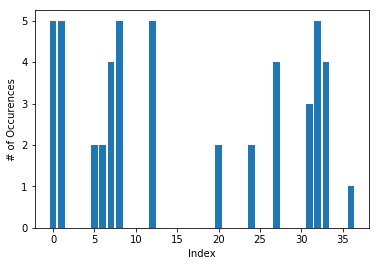

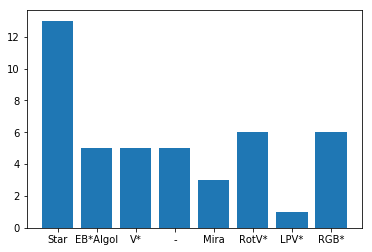

In [52]:
indexes = simbadSearch['index'].tolist()
set(indexes)
foundSum = []
objectTypes =[]
for x in range(1,6):
    tab = ascii.read('/home/mj1e16/outTablesImproved/simbad{}.csv'.format(x))
    df = tab.to_pandas()
    #objectTypes.extend(df)
    df2 = df[df['OTYPE'] != 'Object Not Found']
    objectTypes.extend(df2['OTYPE'])
    indexFound = df2['index'].tolist()
    if x == 1:
        foundorNot = [1 if y in indexFound else 0 for y in indexes]
    else:
        fon = [1 if y in indexFound else 0 for y in indexes]
        foundorNot = [y + z for y,z in zip(fon,foundorNot)]
index = range(len(foundorNot))
discreteOtypes = set(objectTypes)
num = []
for x in discreteOtypes:
    num.append(objectTypes.count(x))
plt.bar(index,foundorNot)
plt.xlabel('Index')
plt.ylabel('# of Occurences')
plt.show()

disoindex = range(len(num))
plt.bar(disoindex,num)
plt.xticks(disoindex, discreteOtypes)
plt.show()

In [403]:
print(foundorNot)

[5, 5, 0, 0, 0, 1, 0, 3, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 3, 4, 3, 0, 0, 0]


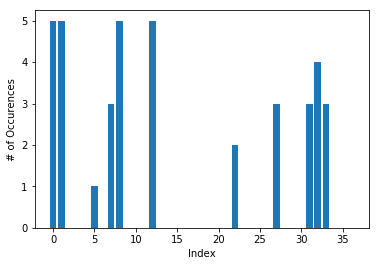

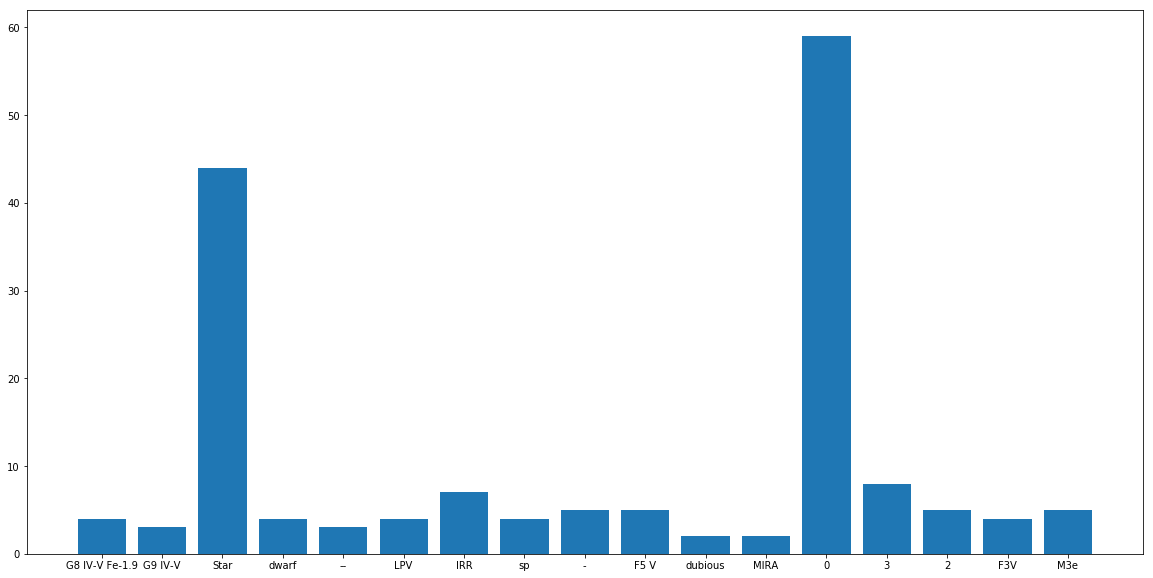

In [56]:
indexes = simbadSearch['index'].tolist()
set(indexes)
foundSum = []
objectTypes =[]

for x in range(1,6):
    tab = ascii.read('/home/mj1e16/outTablesImproved/vizier{}.csv'.format(x))
    df = tab.to_pandas()
    df2 = df[df['CLASS'] != 'Object Not Found']
    df3 = df2[df2['CLASS'] != 'No Object Type']
    objectTypes.extend(df3['CLASS'])
    indexFound = df3['index'].tolist()
    if x == 1:
        foundorNot = [1 if y in indexFound else 0 for y in indexes]
    else:
        fon = [1 if y in indexFound else 0 for y in indexes]
        foundorNot = [y + z for y,z in zip(fon,foundorNot)]
        
#    df3 = df2[df2['CLASS'] != 'No Object Type']
index = range(len(foundorNot))
discreteOtypes = set(objectTypes)
num = []
for x in discreteOtypes:
    num.append(objectTypes.count(x))
    
plt.bar(index,foundorNot)
plt.xlabel('Index')
plt.ylabel('# of Occurences')
plt.show()

disoindex = range(len(num))
plt.figure(figsize=[20,10])
plt.bar(disoindex,num)
plt.xticks(disoindex, discreteOtypes)
plt.show()

In [42]:
num = 1
simbadTab = ascii.read('/home/mj1e16/outTablesImproved/simbad{}.csv'.format(num))
df = simbadTab.to_pandas()
df2 = df[df['OTYPE'] != 'Object Not Found']
df2

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [46]:
num = 2
vizTab = ascii.read('/home/mj1e16/outTablesImproved/vizier{}.csv'.format(num))
df = vizTab.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df3 = df2[df2['CLASS'] != 'No Object Type']
df3

,RA_d,DEC_d,Vmag,CLASS,xcentroid,ycentroid,flux,IMAGE,index
0,0.000000,0.000000,-,-,0.0000,0.0000,0.000,-,0
9,283.158910,47.393770,VMAG,0,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
11,283.158907,47.393826,VMAG,3,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
14,283.158908,47.393827,VMAG,0,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
37,283.159042,47.393847,VMAG,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
38,283.159042,47.393847,VMAG,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
39,283.159042,47.393847,VMAG,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
40,283.159042,47.393847,VMAG,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
56,283.159027,47.393848,VMAG,F3V,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7
58,283.158780,47.393791,VMAG,F5 V,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,7


In [21]:
ascii.write(simbadSearch,'/home/mj1e16/outTablesImproved/simbad2.csv',format='csv',fast_writer=False)

In [232]:
ascii.write(vizierSearch,'/home/mj1e16/outTablesImproved/vizier.csv',format='csv',fast_writer=False)

In [22]:
simbad2 = ascii.read('/home/mj1e16/outTablesImproved/simbad2.csv')

In [7]:
tabTot =  ascii.read('/home/mj1e16/outTablesImproved/sexdiffOutTest.csv')

In [8]:
tabTot = ascii.read('/home/mj1e16/outTablesImproved/firsthalf.csv')

In [61]:
# upload_resource = '/home/mj1e16/outTables15/matchplus3Magdiff.csv'
# j = Gaia.launch_job(query="select * from tap_upload.table_test", upload_resource=upload_resource, \
# upload_table_name="table_test", verbose=True)
# r = j.get_results()
# r.pprint()

In [15]:
def gaiaSearch(table):
    RA = table['RA']
    DEC = table['DEC']
    width = u.Quantity(5., u.arcsecond)
    height = u.Quantity(5., u.arcsecond)
    #coord = [str(RA[0])+','+str(DEC[0])]
    t0 = time.time()
    for x in range(len(RA)):
        coord = SkyCoord(ra=RA[x], dec=DEC[x], unit=(u.degree, u.degree), frame='icrs')
        if x ==0:
            result_table = Gaia.query_object_async(coordinate=coord, width=width, height=height)
        else:
            newtab = Gaia.query_object_async(coordinate=coord, width=width, height=height)
            if len(newtab) != 0:
                result_table.add_row(newtab[0])
    print(time.time() - t0)
    return result_table

In [18]:
def colourMag(table):
    parallax = table['parallax']
    distance = [1./(x/1000.) for x in parallax]
    paraError = table['parallax_error']
    colour = table['bp_rp']
    gmag = table['phot_g_mean_mag']
    extinction = table['a_g_val']


    colourGood = [x for x,y,z in zip(colour,paraError,parallax) if y<0.25*z]
    distanceGood = [x for x,y,z in zip(distance,paraError,parallax) if y<0.25*z]
    gmagGood = [x for x,y,z in zip(gmag,paraError,parallax) if y<0.25*z]
    exctinctionGood = [x for x,y,z in zip(extinction,paraError,parallax) if y<0.25*z]

    absoluteMag = [mag - (5*(np.log10(dist)))  + 5 for mag,dist,ext in zip(gmagGood,distanceGood,exctinctionGood)]
    return {'absMag':absoluteMag,'colour':colourGood}

In [113]:
# RA = tabTot['RA']
# DEC = tabTot['DEC']
# width = u.Quantity(5., u.arcsecond)
# height = u.Quantity(5., u.arcsecond)
# #coord = [str(RA[0])+','+str(DEC[0])]
# t0 = time.time()
# for x in range(10000): #len(RA)):
#     coord = SkyCoord(ra=RA[x], dec=DEC[x], unit=(u.degree, u.degree), frame='icrs')
#     if x ==0:
#         result_table = Gaia.query_object_async(coordinate=coord, width=width, height=height)
#     else:
#         newtab = Gaia.query_object_async(coordinate=coord, width=width, height=height)
#         if len(newtab) != 0:
#             result_table.add_row(newtab[0])
# print(time.time() - t0)

In [12]:
#ascii.write(result_table,'/home/mj1e16/outTablesImproved/gaiaObjects.csv',format='csv',fast_writer=False)
ascii.write(result_table,'/home/mj1e16/outTablesImproved/gaiaTab.csv',format='csv',fast_writer=False)

In [13]:
otherGaiaTab = ascii.read('/home/mj1e16/outTablesImproved/fullMatches.csv')

In [115]:
simbadSearch = queryObjectRegion(otherGaiaTab,searchRadius=5*u.arcsecond)

In [180]:
oclass = vizierSearch['CLASS']
vmag = vizierSearch['Vmag']
simbadSearch['Vmag'] = vmag
simbadSearch['Class'] = oclass
simbadSearch

MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE,Vmag,Class
object,float64,float64,object,float64,float64,float64,object,object,object
-,0.0,0.0,-,0.0,0.0,0.0,-,0,-
N/A,291.9081476036849,47.058497168533194,Object Not Found,429.9972,24.7407,4972.103,diff_imNo11_channel18_ccd58.fits,[0],Object Not Found
N/A,282.2997286819453,48.51511298543987,Object Not Found,618.8993,260.8472,2963.834,diff_imNo49_channel12_ccd16.fits,[0],Object Not Found
N/A,286.17639521590405,44.443401074095455,Object Not Found,127.6044,916.9813,2797.135,diff_imNo49_channel26_ccd18.fits,[0],Object Not Found
N/A,282.51787304188844,47.587614950317615,Object Not Found,1039.0616,993.9548,2862.116,diff_imNo14_channel12_ccd76.fits,[0],Object Not Found
2MASS J19044019+3740211,286.1674519875751,37.6725297870107,RGB*,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits,VMAG,0
KIC 6267115,284.7196699802004,41.6760072017319,Star,947.2881,593.7286,3451.97,diff_imNo25_channel49_ccd49.fits,[0],Object Not Found
2MASS J19393539+4900241,294.897456592791,49.0067104408479,RGB*,645.012,273.612,3651.136,diff_imNo31_channel13_ccd13.fits,VMAG,0
KIC 10256300,283.1588365335496,47.3937710691911,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits,VMAG,0


In [182]:
ascii.write(simbadSearch,'/home/mj1e16/outTablesImproved/otypes.csv',format='csv',fast_writer=False)

In [154]:
vizierSearch = queryObjectRegionVizier(otherGaiaTab,searchRadius=5*u.arcsecond)
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df2

Empty TableList
Empty TableList
Empty TableList
Empty TableList
TableList with 2 tables:
	'0:I/271/out' with 4 column(s) and 1 row(s) 
	'1:I/305/out' with 4 column(s) and 1 row(s) 
  _RAJ2000     _DEJ2000   Class  _V 
    deg          deg                
------------ ------------ ----- ----
286.16748900  37.67248900     0 VMAG
Empty TableList
TableList with 4 tables:
	'0:I/254/out' with 4 column(s) and 1 row(s) 
	'1:I/255/out' with 4 column(s) and 1 row(s) 
	'2:I/271/out' with 4 column(s) and 1 row(s) 
	'3:I/305/out' with 4 column(s) and 1 row(s) 
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ----- ----
294.8974900  49.0067900     0 VMAG
TableList with 4 tables:
	'0:I/254/out' with 4 column(s) and 1 row(s) 
	'1:I/255/out' with 4 column(s) and 1 row(s) 
	'2:I/271/out' with 4 column(s) and 2 row(s) 
	'3:I/305/out' with 4 column(s) and 2 row(s) 
  _RAJ2000    _DEJ2000  Class  _V 
    deg         deg               
----------- ----------- ---

In [157]:
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
df2

,MAIN_ID,RA_d,DEC_d,CLASS,Vmag,xcentroid,ycentroid,flux,IMAGE
0,-,0.0,0.0,-,0.0,0.0,0.0,0.0,-


In [128]:
df = vizierSearch.to_pandas()
df2 = df[df['CLASS'] != 'Object Not Found']
smallTab = Table.from_pandas(df2)
smallTab

MAIN_ID,RA_d,DEC_d,CLASS,Vmag,xcentroid,ycentroid,flux,IMAGE
str1,float64,float64,str1,float64,float64,float64,float64,str1
-,0.0,0.0,-,0.0,0.0,0.0,0.0,-


In [117]:
df = simbadSearch.to_pandas()
df2 = df[df['OTYPE'] != 'Object Not Found']
smallTab = Table.from_pandas(df2)
smallTab

MAIN_ID,RA_d,DEC_d,OTYPE,xcentroid,ycentroid,flux,IMAGE
str23,float64,float64,str8,float64,float64,float64,str32
-,0.0,0.0,-,0.0,0.0,0.0,-
2MASS J19044019+3740211,286.1674519875751,37.6725297870107,RGB*,341.8187,226.6804,3784.545,diff_imNo28_channel71_ccd75.fits
KIC 6267115,284.7196699802004,41.6760072017319,Star,947.2881,593.7286,3451.97,diff_imNo25_channel49_ccd49.fits
2MASS J19393539+4900241,294.897456592791,49.0067104408479,RGB*,645.012,273.612,3651.136,diff_imNo31_channel13_ccd13.fits
KIC 10256300,283.1588365335496,47.3937710691911,Star,847.0221,792.5739,4922.818,diff_imNo31_channel9_ccd9.fits
KOI-6167,283.0662745616069,43.7435568227975,EB*Algol,851.0325,318.8774,4745.73,diff_imNo40_channel30_ccd54.fits


In [17]:
newGaiaTab = gaiaSearch(otherGaiaTab)

Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
16.1608419418


In [22]:
# if using a table previously made
#result_table = ascii.read('/home/mj1e16/outTablesImproved/gaiaTab.csv')

In [23]:
refmagandcolour = colourMag(result_table)

In [24]:
magandcolour =colourMag(newGaiaTab)

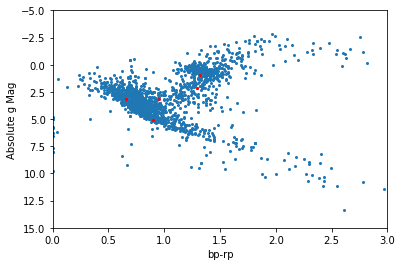

In [25]:
plt.plot(refmagandcolour['colour'],refmagandcolour['absMag'],'o',markersize=2)
plt.plot(magandcolour['colour'],magandcolour['absMag'],'ro',markersize=2)
plt.ylim([-5,15])
plt.xlim([0,3])
plt.gca().invert_yaxis()
plt.ylabel('Absolute g Mag')
plt.xlabel('bp-rp')
plt.show()

In [27]:
gaiaMag = result_table['phot_g_mean_mag']
keplerMag = tabTot['MAG_BEST'][0:10000]

In [37]:
def testfindMatches(tabTot,matchTab,arcsec=2.5*u.arcsec,low=0,high=10000):
    tabMini = tabTot[low:high]
    matches = 'not matched'
    ra1 = matchTab['ra']
    dec1 = matchTab['dec']
    idx = []
    ra2 = tabMini['RA']
    dec2 = tabMini['DEC']    
    c = SkyCoord(ra=ra1, dec=dec1,unit=(u.hourangle,u.deg),frame='fk5')
    catalog = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
    idx, d2d, d3d = c.match_to_catalog_sky(catalog)
    sep_constraint = d2d < max_sep
#     print(len(matches))
#     print(matches)
    tabMini.remove_rows(idx)
    objectsFound = number1[sep_constraint]
    origdf = bigdf[bigdf['NUMBER'].isin(objectsFound)]
    return tabMini

In [99]:
def findMatchesNoCondition(tab,match,df,bigdf,max_sep = 2.5 * u.arcsec):
    
    number1 = match['index']
    ra1 = match['ra']
    dec1 = match['dec']

    number2 = tab['index'] # difference image
    ra2 = tab['RA']
    dec2 = tab['DEC']    
    
    cat1 = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
    cat2 = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
    
    idx, d2d, d3d = cat2.match_to_catalog_sky(cat1)
    sep_constraint = d2d < max_sep
    objectsFound = number2[sep_constraint]
    matchdf = df[df['index'].isin(objectsFound)]
    matchTab = Table.from_pandas(matchdf)

    idx, d2d, d3d = cat1.match_to_catalog_sky(cat2)
    sep_constraint = d2d < max_sep
    #istrue = [x for x in sep_constraint if x == True]
    objectsFound = number1[sep_constraint]
    origdf = bigdf[bigdf['index'].isin(objectsFound)]
    origTab = Table.from_pandas(origdf)
    
    return [matchTab,origTab]

In [93]:
indexes = [i for i in range(10000)]
rtindexes = [i for i in range(len(result_table))]
tabMini = tabTot[0:10000]
tabMini['index'] = indexes
result_table['index'] = rtindexes
df = tabMini.to_pandas()
bigdf = result_table.to_pandas()

In [100]:
match = findMatchesNoCondition(tabMini,result_table,df,bigdf)

In [105]:
match[1]

dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,index
float64,int64,str28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,str5,float64,float64,float64,float64,int64,int64,float64,int64,int64,str5,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,str77,str99,int64
0.0004856895386947052,1635721458409799680,Gaia DR2 2101397003944879744,2101397003944879744,1460115014,2015.5,290.1541864197112,0.5432112779766552,40.9350567951846,0.7683634845762366,-1.3875383085515758,0.6925544086393817,-2.003508,-1.6469723906519274,1.1554458124932419,0.02832046423850106,1.7692631528420302,0.08079609,0.26672313,0.08902849,-0.30213055,0.26576456,-0.3175182,-0.115155965,-0.06868647,0.057202842,0.013251644,167,0,167,0,1.933488,198.58994,1.4973966196441795,0.7626853853394648,31,False,0.037213326,1.7492072531715066,0.1656579173208149,0.21154217,20,14,1.5636353,0,22,False,185,115.98480231678155,0.9944445855181093,116.632744,20.527363,14,96.61784003532408,15.769214245003758,6.1269913,20.388744,15,109.9780189881386,9.456519384464732,11.629863,19.658655,1.7812321,0,0.7300892,-0.13861847,0.86870766,0.0,0.0,0,0.0,0.0,0.0,NOT_AVAILABLE,72.8462236301454,12.321236533507404,303.7161711816616,62.03556137263401,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,http://geadata.esac.esa.int/data-server/datalink/links?ID=2101397003944879744,--,0
0.0004220522502123424,1635721458409799680,Gaia DR2 2101399306052024832,2101399306052024832,760687150,2015.5,290.3191674090691,0.01146370356861856,41.038643828467215,0.013157286534784192,2.6444742383694697,0.014254419301190787,185.5196,-5.097038692635611,0.02495669795514842,-0.9655807078618102,0.02803366587614792,0.030564,0.00073369377,-0.053977344,-0.042234153,0.19177416,-0.077061795,-0.1397227,-0.18708868,-0.16435198,0.062010564,235,0,233,2,-4.561351,143.31865,0.0,0.0,31,True,91.91692,1.5463240794613022,0.0035608379413206246,0.09213

In [104]:
match[0]

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index
int64,float64,float64,float64,float64,float64,float64,float64,float64,str34,str18,str32,int64
7,11456.36,280.9146,14.8524,574.5563,1008.829,0.434,290.154244155043,40.93553403531398,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,6
10,2277.93,34.05597,16.6061,429.0159,992.2977,0.058,290.3189672067992,41.03903357582664,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,9
16,3054.787,57.26656,16.2875,431.1161,902.2485,0.255,290.24398542974404,41.12090268582241,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,15
20,3052.171,35.77414,16.2885,1067.9397,878.5374,0.074,289.44881212003037,40.75399198948763,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,19
25,643.2305,26.07466,17.9791,906.3129,742.7368,0.252,289.5346598957401,40.97787958211275,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,24
37,2050.519,31.83027,16.7203,757.8644,625.5156,0.049,289.62014431369175,41.176573052631966,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,36
51,1316.578,21.60069,17.2014,846.3585,411.3842,0.136,289.3370440227031,41.31871402777068,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,50
59,3098.985,36.51183,16.272,521.098,316.912,0.171,289.6580544878012,41.605185276102596,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,58
61,10156.0,43.35539,14.9832,761.9088,241.4618,0.003,289.3006230731252,41.52648056165964,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,60


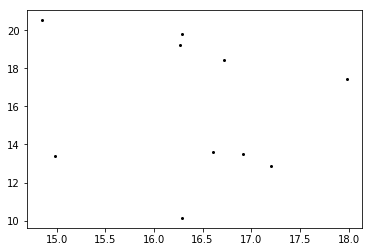

In [112]:
keplerMag = match[0]['MAG_BEST']
gaiaMag = match[1]['phot_g_mean_mag']
plt.plot(keplerMag[0:10],gaiaMag[0:10],'ko',markersize=2)
plt.show()

In [110]:
match[0][0:10]

NUMBER,FLUX_BEST,FLUXERR_BEST,MAG_BEST,X_IMAGE,Y_IMAGE,ELLIPTICITY,RA,DEC,IMAGE_NAME,MEDIAN_NAME,DIFF_NAME,index
int64,float64,float64,float64,float64,float64,float64,float64,float64,str34,str18,str32,int64
7,11456.36,280.9146,14.8524,574.5563,1008.829,0.434,290.154244155043,40.93553403531398,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,6
10,2277.93,34.05597,16.6061,429.0159,992.2977,0.058,290.3189672067992,41.03903357582664,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,9
16,3054.787,57.26656,16.2875,431.1161,902.2485,0.255,290.24398542974404,41.12090268582241,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,15
20,3052.171,35.77414,16.2885,1067.9397,878.5374,0.074,289.44881212003037,40.75399198948763,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,19
25,643.2305,26.07466,17.9791,906.3129,742.7368,0.252,289.5346598957401,40.97787958211275,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,24
37,2050.519,31.83027,16.7203,757.8644,625.5156,0.049,289.62014431369175,41.176573052631966,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,36
51,1316.578,21.60069,17.2014,846.3585,411.3842,0.136,289.3370440227031,41.31871402777068,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,50
59,3098.985,36.51183,16.272,521.098,316.912,0.171,289.6580544878012,41.605185276102596,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,58
61,10156.0,43.35539,14.9832,761.9088,241.4618,0.003,289.3006230731252,41.52648056165964,kplr2012310200152_ffi-cal.fits[58],meidian_66_58.fits,diff_imNo23_channel66_ccd58.fits,60


In [111]:
match[1][0:10]

dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,index
float64,int64,str28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,str5,float64,float64,float64,float64,int64,int64,float64,int64,int64,str5,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,str77,str99,int64
0.0004856895386947052,1635721458409799680,Gaia DR2 2101397003944879744,2101397003944879744,1460115014,2015.5,290.1541864197112,0.5432112779766552,40.9350567951846,0.7683634845762366,-1.3875383085515758,0.6925544086393817,-2.003508,-1.6469723906519274,1.1554458124932419,0.02832046423850106,1.7692631528420302,0.08079609,0.26672313,0.08902849,-0.30213055,0.26576456,-0.3175182,-0.115155965,-0.06868647,0.057202842,0.013251644,167,0,167,0,1.933488,198.58994,1.4973966196441795,0.7626853853394648,31,False,0.037213326,1.7492072531715066,0.1656579173208149,0.21154217,20,14,1.5636353,0,22,False,185,115.98480231678155,0.9944445855181093,116.632744,20.527363,14,96.61784003532408,15.769214245003758,6.1269913,20.388744,15,109.9780189881386,9.456519384464732,11.629863,19.658655,1.7812321,0,0.7300892,-0.13861847,0.86870766,0.0,0.0,0,0.0,0.0,0.0,NOT_AVAILABLE,72.8462236301454,12.321236533507404,303.7161711816616,62.03556137263401,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,http://geadata.esac.esa.int/data-server/datalink/links?ID=2101397003944879744,--,0
0.0004220522502123424,1635721458409799680,Gaia DR2 2101399306052024832,2101399306052024832,760687150,2015.5,290.3191674090691,0.01146370356861856,41.038643828467215,0.013157286534784192,2.6444742383694697,0.014254419301190787,185.5196,-5.097038692635611,0.02495669795514842,-0.9655807078618102,0.02803366587614792,0.030564,0.00073369377,-0.053977344,-0.042234153,0.19177416,-0.077061795,-0.1397227,-0.18708868,-0.16435198,0.062010564,235,0,233,2,-4.561351,143.31865,0.0,0.0,31,True,91.91692,1.5463240794613022,0.0035608379413206246,0.09213